## Neural Collaborative Filtering (NCF)
<img src="https://recodatasets.blob.core.windows.net/images/NCF.svg?sanitize=true">

# 데이터 생성

In [2]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', 25)

df = pd.read_json(os.path.join("..","..","data","TA_User_Reviws_Korea_all.json"))

# 사용할 열만 가져옴. 
COLUMNS = ['rating', 'userId', 'location.locationId', 'location.placeType', 'location.reviewSummary.count', 'location.reviewSummary.rating', 'location.reviewSummary.locationId', 'tripInfo.stayDate', 'userProfile.hometown.location.name']
# 결측치 행 제거 
df = df.loc[:,COLUMNS].dropna(axis=0)
df.head()

,rating,userId,location.locationId,location.placeType,location.reviewSummary.count,location.reviewSummary.rating,location.reviewSummary.locationId,tripInfo.stayDate,userProfile.hometown.location.name
1,5,23EF5413495FF530151DB7E5C0FEF38D,1958940,ATTRACTION,2256.0,4.5,1958940.0,2020-01-31,Jakarta
2,4,23EF5413495FF530151DB7E5C0FEF38D,5979642,EATERY,25.0,4.5,5979642.0,2020-01-31,Jakarta
3,5,23EF5413495FF530151DB7E5C0FEF38D,13426084,ACCOMMODATION,232.0,4.5,13426084.0,2020-01-31,Jakarta
4,4,23EF5413495FF530151DB7E5C0FEF38D,553546,ATTRACTION,10353.0,4.5,553546.0,2019-12-31,Jakarta
5,4,23EF5413495FF530151DB7E5C0FEF38D,324891,ATTRACTION,3111.0,4.0,324891.0,2019-12-31,Jakarta


In [ ]:
# 날짜 데이터 변경 
from datetime import datetime
def convert_date(str_date):
  return datetime.strptime(str_date, "%Y-%m-%d").date()

df['stayDate'] = df['tripInfo.stayDate'].apply(convert_date)

# uesrid int형 생성 
users = df.groupby('userId')['userId'].agg([('users','count')]).reset_index().reset_index().iloc[:,:2]
new_df = pd.merge(users,df, on='userId').rename(columns={'index':'userID'})
print(new_df.info())

# 불필요 열 삭제 
new_df = new_df.drop(['userId','tripInfo.stayDate'], axis=1)
new_df.head()

,userID,rating,location.locationId,location.placeType,location.reviewSummary.count,location.reviewSummary.rating,location.reviewSummary.locationId,userProfile.hometown.location.name,stayDate
0,0,4,306130,ACCOMMODATION,4033.0,4.5,306130.0,Jakarta,2016-02-29
1,0,2,6352819,ATTRACTION,276.0,4.5,6352819.0,Jakarta,2016-02-29
2,1,5,9033360,EATERY,10.0,4.5,9033360.0,Seoul,2015-08-31
3,1,5,9017499,EATERY,8.0,4.0,9017499.0,Seoul,2015-11-30
4,1,5,4076062,EATERY,7.0,4.0,4076062.0,Seoul,2015-06-30


# train, test 데이터셋

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.externals import joblib 
import joblib
import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
from keras import metrics

#### Read Data

In [16]:
new_df = pd.read_csv(os.path.join("..","..","data","TA_User_Reviws_Korea_all_new_df.csv"))
new_df.head(5)

,userID,rating,location.locationId,location.placeType,location.reviewSummary.count,location.reviewSummary.rating,location.reviewSummary.locationId,userProfile.hometown.location.name,stayDate
0,0,4,306130,ACCOMMODATION,4033.0,4.5,306130.0,Jakarta,2016-02-29
1,0,2,6352819,ATTRACTION,276.0,4.5,6352819.0,Jakarta,2016-02-29
2,1,5,9033360,EATERY,10.0,4.5,9033360.0,Seoul,2015-08-31
3,1,5,9017499,EATERY,8.0,4.0,9017499.0,Seoul,2015-11-30
4,1,5,4076062,EATERY,7.0,4.0,4076062.0,Seoul,2015-06-30


In [ ]:
# Data Columns 
USER, ITEM, RATING = 'userID', 'location.locationId', 'rating'

In [ ]:
from sklearn.model_selection import train_test_split

df = new_df.loc[:,['userID','location.locationId', 'rating']]
train, test = train_test_split(df, test_size=0.33, random_state=42)
print(train.shape, test.shape)

(19135, 3) (9426, 3)


In [ ]:
# user_id와 item_id를 0 ~ (id갯수-1)로 바꿔서 embedding layer에 입력 => NN의 weight를 줄이기 위해
vocab_users = {}
num_users = 0
for i in np.hstack([train[USER], test[USER]]): 
    if vocab_users.get(i) != None:
        continue
    vocab_users[i] = num_users
    num_users += 1
    
vocab_items = {}
num_items = 0
for i in np.hstack([train[ITEM], test[ITEM]]):
    if vocab_items.get(i) != None:
        continue
    vocab_items[i] = num_items
    num_items += 1 
    
encoded_users = [vocab_users[i] for i in train[USER]]
encoded_items = [vocab_items[i] for i in train[ITEM]]    

#### Build NCF Model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 8)         36480       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 8)         78488       item_input[0][0]                 
____________________________________________________________________________________________

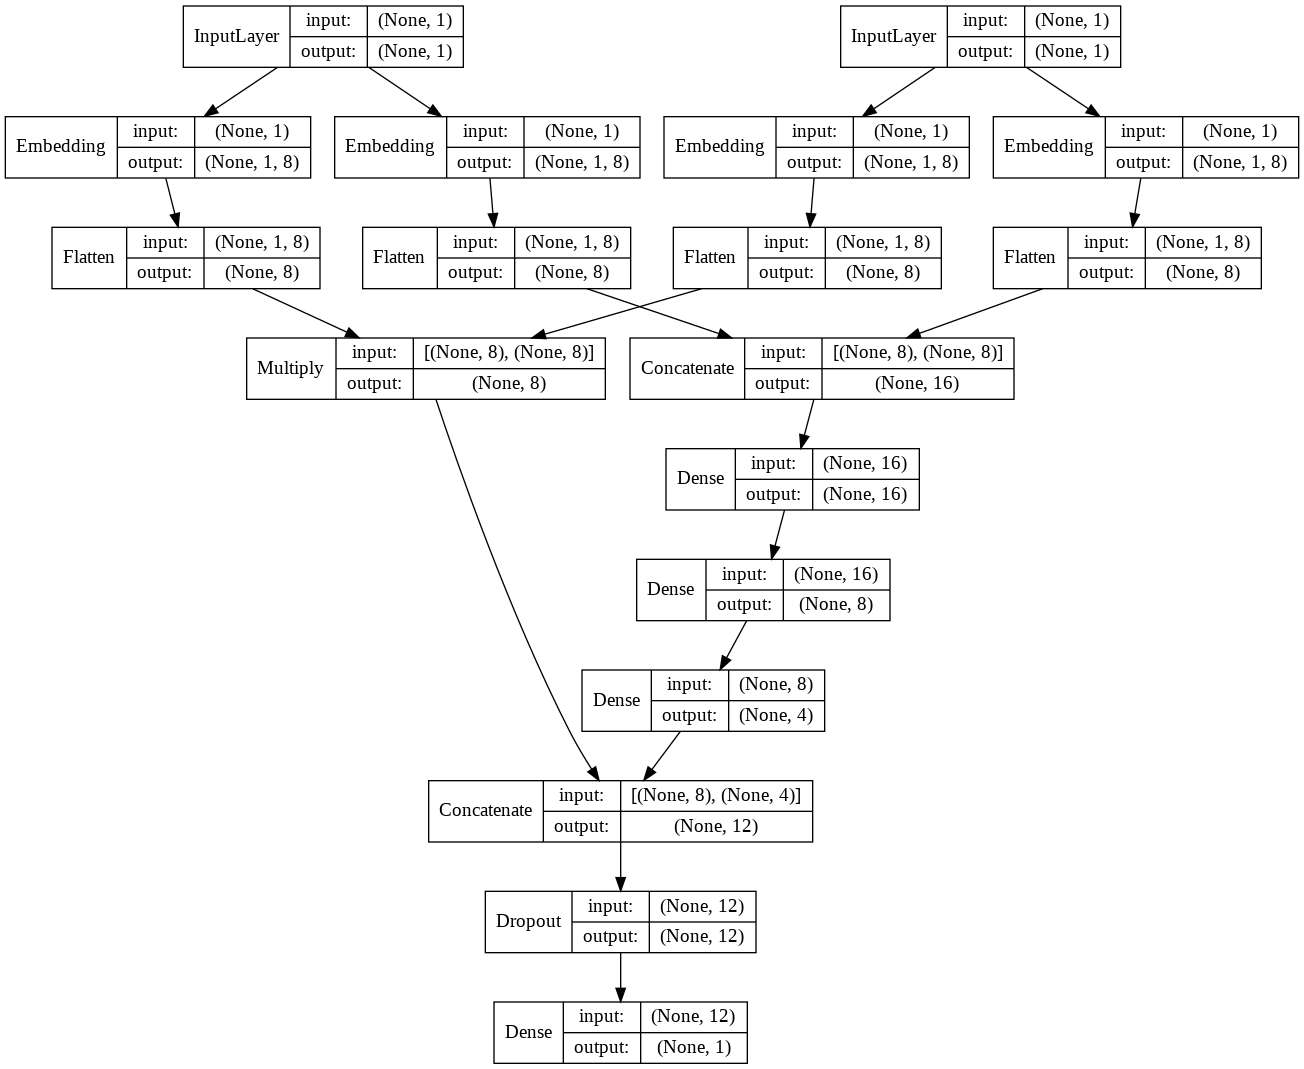

In [ ]:
n_factors = 8  # 클수록 성능이 좋다고 함 ???
layers = [16, 8, 4] 

# Input variables
user_input = Input(shape=(1,), dtype='int64', name = 'user_input')
item_input = Input(shape=(1,), dtype='int64', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = num_users, output_dim = n_factors, 
                              name = 'mf_embedding_user', input_length=1)(user_input)
MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = n_factors,
                              name = 'mf_embedding_item', input_length=1)(item_input)   

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0] // 2,
                               name = "mlp_embedding_user", input_length=1)(user_input)
MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0] // 2,
                               name = 'mlp_embedding_item', input_length=1)(item_input)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User)
mf_item_latent = Flatten()(MF_Embedding_Item)
mf_vector = Multiply()([mf_user_latent, mf_item_latent]) 

# MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User)
mlp_item_latent = Flatten()(MLP_Embedding_Item)
mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
# Layer 쌓는 층 
for idx in range(len(layers)):
    mlp_vector = Dense(layers[idx], activation='elu', name=f"layer{idx}")(mlp_vector)

# Concatenate MF and MLP parts
predict_vector = Concatenate()([mf_vector, mlp_vector])
predict_vector = Dropout(0.3)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector)

model = Model([user_input, item_input], prediction)
model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=1e-3), metrics=[metrics.mse])

model.summary()
Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 17221 samples, validate on 1914 samples
Epoch 1/10
 - 1s - loss: 13.5524 - mean_squared_error: 13.5524 - val_loss: 9.4320 - val_mean_squared_error: 9.4320
Epoch 2/10
 - 0s - loss: 6.7148 - mean_squared_error: 6.7148 - val_loss: 3.9360 - val_mean_squared_error: 3.9361
Epoch 3/10
 - 0s - loss: 3.2994 - mean_squared_error: 3.2994 - val_loss: 1.3734 - val_mean_squared_error: 1.3734
Epoch 4/10
 - 0s - loss: 2.5751 - mean_squared_error: 2.5751 - val_loss: 1.1018 - val_mean_squared_error: 1.1018
Epoch 5/10
 - 0s - loss: 2.3324 - mean_squared_error: 2.3324 - val_loss: 1.0743 - val_mean_squared_error: 1.0743
Epoch 6/10
 - 0s - loss: 2.1733 - mean_squared_error: 2.1733 - val_loss: 0.9088 - val_mean_squared_error: 0.9088
Epoch 7/10
 - 0s - loss: 2.0381 - mean_squared_error: 2.0381 - val_loss: 0.9251 - val_mean_squared_error: 0.9251
Epoch 8/10
 - 0s - loss: 1.9151 - mean_squared_error: 1.9151 - val_loss: 0.9510 - val_mean_squared_error: 0.9510
Epoch 9/10
 - 0s - loss: 1.8889 - mean_square

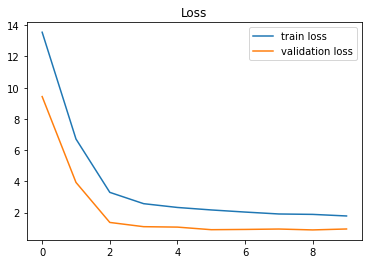

In [ ]:
history = model.fit(x=[encoded_users, encoded_items], y=train[RATING], 
                    batch_size=256, epochs=10, validation_split=0.1, 
                    callbacks=[EarlyStopping(patience=3)], verbose=2)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

#### Evaluate NCF Model

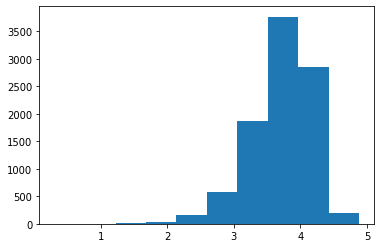

In [ ]:
# 예측 rating(0~1) 빈도 도식화
plt.hist(model.predict([[vocab_users[i] for i in test[USER]], 
                        [vocab_items[i] for i in test[ITEM]]]))
plt.show()

In [ ]:
# 정확도 측정
model.evaluate([[vocab_users[i] for i in test[USER]], [vocab_items[i] for i in test[ITEM]]],
               test[RATING])[1]

9426/9426 [==============================] - 0s 23us/step


0.9104800224304199

In [ ]:
# 모형 저장
joblib.dump(model, 'ncf_model.pkl')

['ncf_model.pkl']

In [ ]:
top_k = 10
test_users = 100

# 각 사용자별 추천 리스트 데이터 프레임 형식으로 출력
recs = []
prob = []
test_uid = np.sort(test[USER].unique()[:test_users])
for i, u in enumerate(test_uid):
    pred = model.predict([[vocab_users[u]]*len(vocab_items), range(len(vocab_items))]).flatten()
    rec = set([list(vocab_items.keys())[i] for i in np.argsort(-pred)[:top_k]])
    recs.append(rec)
    prob.append([i for i in np.sort(pred)[::-1][:top_k]])
    
recs = pd.DataFrame(pd.DataFrame(recs, index=test_uid).stack()).reset_index(). \
                    rename({'level_0':USER, 0: ITEM}, axis=1).iloc[:,[0,2]]
prob = pd.DataFrame(prob, index=test_uid).stack().reset_index().rename({0: 'score'}, axis=1).iloc[:,[2]]
recs_prob = pd.concat([recs, prob], axis=1)

recs_prob    

,userID,location.locationId,score
0,13,554528,4.441859
1,13,5113510,4.390379
2,13,8587847,4.389069
3,13,554537,4.385108
4,13,12101833,4.371226
...,...,...,...
995,4488,12690380,3.944854
996,4488,8076685,3.936210
997,4488,8522933,3.936204
998,4488,3656150,3.933289


# 성능이 좋음 -> 전체 데이터를 학습시켜 잘 임베딩된 item vector를 사용할 예정

In [ ]:
# Data Columns 
USER, ITEM, RATING = 'userID', 'location.locationId', 'rating'

In [ ]:
# user_id와 item_id를 0 ~ (id갯수-1)로 바꿔서 embedding layer에 입력 => NN의 weight를 줄이기 위해
vocab_users = {}
num_users = 0
for i in new_df[USER]: 
    if vocab_users.get(i) != None:
        continue
    vocab_users[i] = num_users
    num_users += 1 
    
vocab_items = {}
num_items = 0
for i in new_df[ITEM]:
    if vocab_items.get(i) != None:
        continue
    vocab_items[i] = num_items
    num_items += 1 
    
encoded_users = [vocab_users[i] for i in new_df[USER]]
encoded_items = [vocab_items[i] for i in new_df[ITEM]]    

#### Build NCF Model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 16)        72960       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 16)        156976      item_input[0][0]                 
____________________________________________________________________________________________

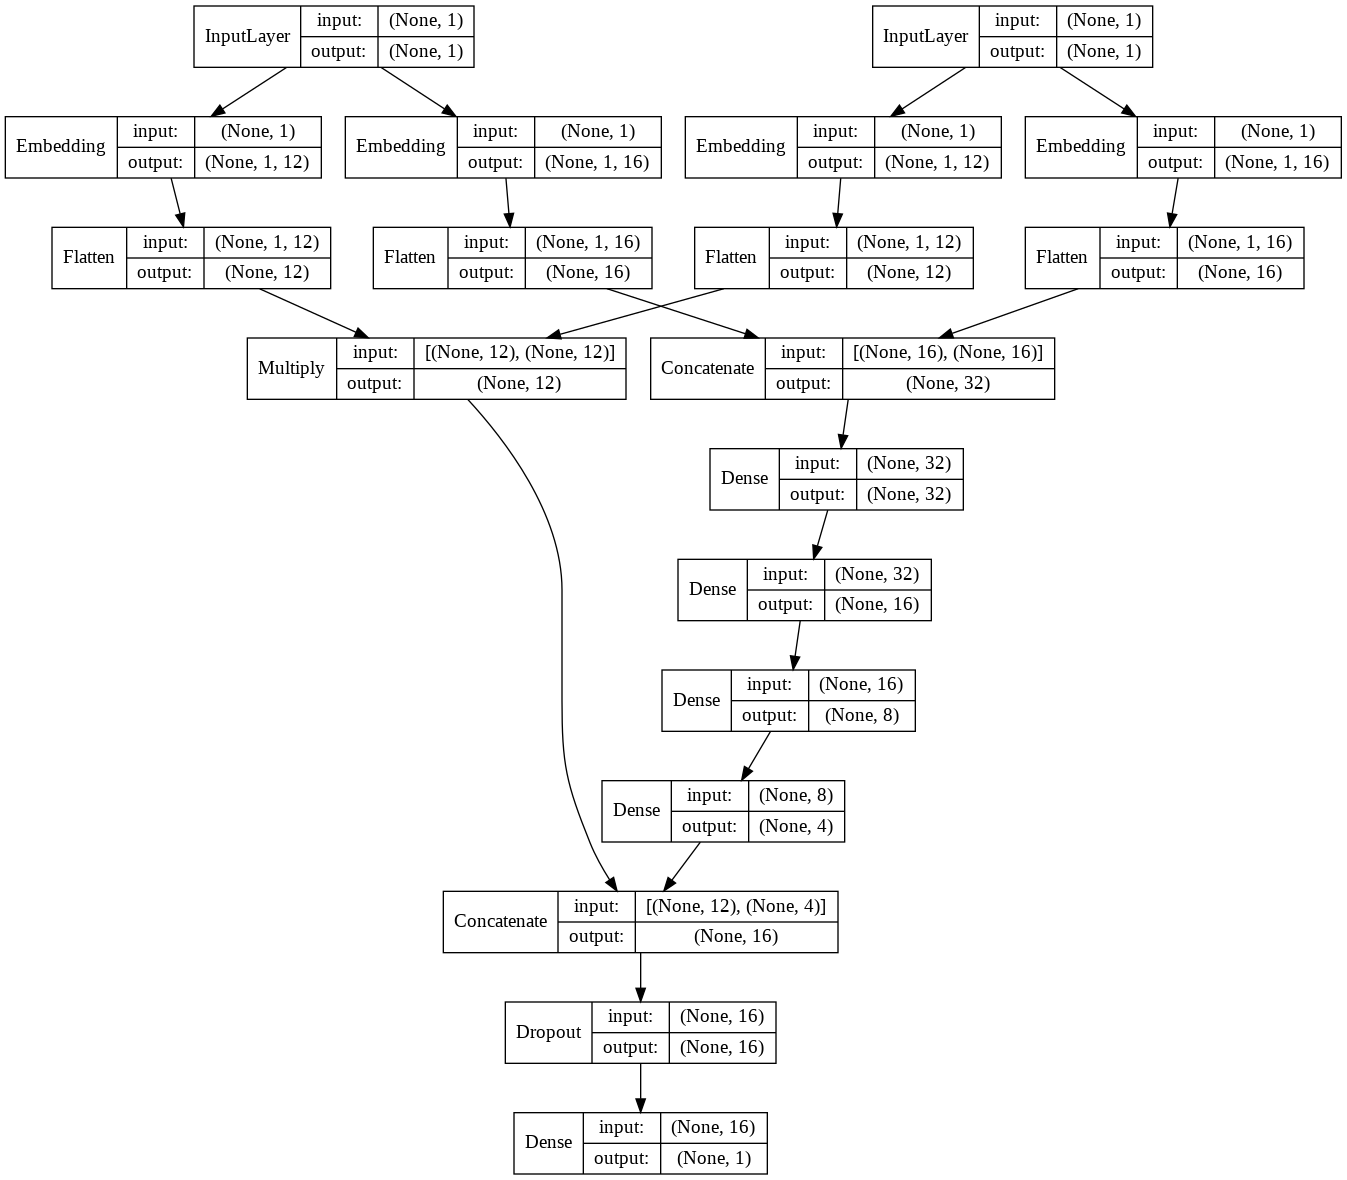

In [20]:
n_factors = 12  # 클수록 성능이 좋다고 함 ???
layers = [32, 16, 8, 4]

# Input variables
user_input = Input(shape=(1,), dtype='int64', name = 'user_input')
item_input = Input(shape=(1,), dtype='int64', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = num_users, output_dim = n_factors, 
                              name = 'mf_embedding_user', input_length=1)(user_input)
MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = n_factors,
                              name = 'mf_embedding_item', input_length=1)(item_input)   

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0] // 2,
                               name = "mlp_embedding_user", input_length=1)(user_input)
MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0] // 2,
                               name = 'mlp_embedding_item', input_length=1)(item_input)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User)
mf_item_latent = Flatten()(MF_Embedding_Item)
mf_vector = Multiply()([mf_user_latent, mf_item_latent])

# MLP part     
mlp_user_latent = Flatten()(MLP_Embedding_User)
mlp_item_latent = Flatten()(MLP_Embedding_Item)
mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])


# Layer 쌓는 층 
for idx in range(len(layers)):
    mlp_vector = Dense(layers[idx], activation='elu', name=f"layer{idx}")(mlp_vector)

# Concatenate MF and MLP parts
predict_vector = Concatenate()([mf_vector, mlp_vector])
predict_vector = Dropout(0.3)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector)

model = Model([user_input, item_input], prediction)
model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=1e-3), metrics=[metrics.mse])


model.summary()
Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25704 samples, validate on 2857 samples
Epoch 1/10
 - 1s - loss: 12.8736 - mean_squared_error: 12.8736 - val_loss: 9.7370 - val_mean_squared_error: 9.7370
Epoch 2/10
 - 1s - loss: 8.2279 - mean_squared_error: 8.2279 - val_loss: 6.8386 - val_mean_squared_error: 6.8386
Epoch 3/10
 - 1s - loss: 5.9018 - mean_squared_error: 5.9018 - val_loss: 4.6487 - val_mean_squared_error: 4.6487
Epoch 4/10
 - 0s - loss: 4.1766 - mean_squared_error: 4.1766 - val_loss: 2.9661 - val_mean_squared_error: 2.9661
Epoch 5/10
 - 0s - loss: 2.9645 - mean_squared_error: 2.9645 - val_loss: 1.7765 - val_mean_squared_error: 1.7765
Epoch 6/10
 - 0s - loss: 2.2269 - mean_squared_error: 2.2269 - val_loss: 1.0908 - val_mean_squared_error: 1.0908
Epoch 7/10
 - 0s - loss: 1.9857 - mean_squared_error: 1.9857 - val_loss: 1.0283 - val_mean_squared_error: 1.0283
Epoch 8/10
 - 0s - loss: 1.8608 - mean_squared_error: 1.8608 - val_loss: 1.3824 - val_mean_squared_error: 1.3824
Epoch 9/10
 - 0s - loss: 1.6929 - mean_square

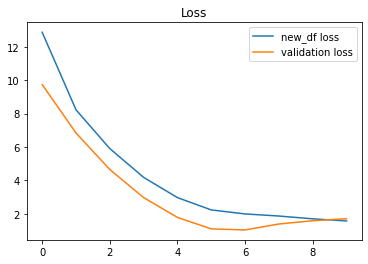

In [21]:
history = model.fit(x=[encoded_users, encoded_items], y=new_df[RATING], 
                    batch_size=256, epochs=10, validation_split=0.1, 
                    callbacks=[EarlyStopping(patience=3)], verbose=2)

plt.plot(history.history["loss"], label="new_df loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()